### Problem 1: 
#### Create a “black-box” function in Python so that you can generate your [𝑋, 𝑌] data. Select your sampling design and collect the data that you will use for fitting and validating. Clearly state your decisions with respect to the number of points you decided to collect, and the type of “experimental” design you used. In your results, show your actual data

In [7]:
import warnings
warnings.simplefilter("ignore")


In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import math

In [9]:
# pip install pyDOE

In [10]:
from pyDOE import *  

np.random.seed(0)

x1_scale = 10-(-5)
x2_scale = 15 - 0
lhd = lhs(2, samples=300, criterion = 'center')  # Use Latin-Hypercube to design the spaces between samples with range [0, 1]   
x1 = -5 + x1_scale * lhd[:, 0] # Convert the range [0, 1] to the actual sample bounded region 
x2 = 0 + x2_scale *lhd[:, 1]  # Convert the range [0, 1] to the actual sample bounded region
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
X_ = np.hstack((x1, x2)) # Construct the numpy array X 
print(X_[:5,:])

[[ 1.875  2.075]
 [ 9.475  0.175]
 [ 4.775  9.225]
 [ 2.025  6.725]
 [ 8.825 10.925]]


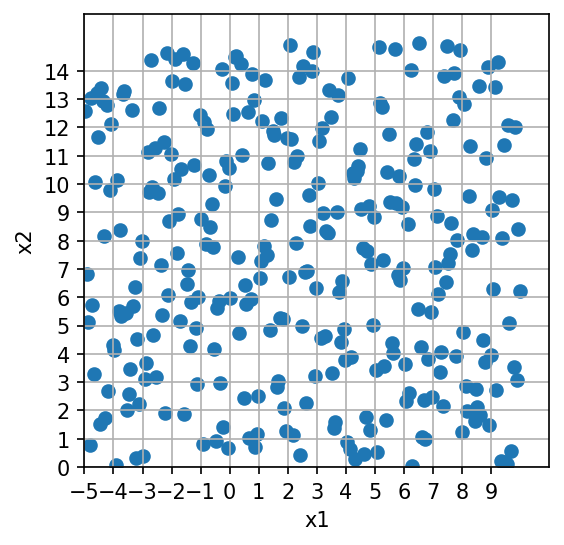

In [11]:
fig, ax = plt.subplots(figsize = (4, 4), dpi=150)
ax.scatter(X_[:,0], X_[:, 1])
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(-5, 11)
ax.set_ylim(0, 16)
ax.set_xticks(np.arange(-5, 10, 1))
ax.set_yticks(np.arange(0, 15, 1))
plt.grid()

In [12]:
Y = []
for i in range(X_.shape[0]):    
    y = 10 + 10*(1 - 1/(8*np.pi))*math.cos(X_[i, 0]) + (X_[i, 1] - (5.1/(16*(np.pi)**2))*(X_[i, 0])**2 + 5/np.pi*X_[i,0] - 6)**2
    Y.append(y)
Y = np.array(Y)
print(Y[:5])

[  8.23557514  40.80270307 112.37413102  20.34478699 272.84681748]


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_)

In [14]:
print('X_ before scaling: {} \n X after scaling: {}'.format(X_[:5, :], X[:5, :]))

X_ before scaling: [[ 1.875  2.075]
 [ 9.475  0.175]
 [ 4.775  9.225]
 [ 2.025  6.725]
 [ 8.825 10.925]] 
 X after scaling: [[-0.14433837 -1.25285704]
 [ 1.6108162  -1.69164569]
 [ 0.52539166  0.3983739 ]
 [-0.10969716 -0.17897958]
 [ 1.4607043   0.79097426]]


### Problem 2: 
#### Use the data you collected in Problem 1 to fit the functions given below. Formulate your parameter estimation problems in Pyomo and use Lasso as your objective function. (You are not allowed to use scikit learn for this). 
#### • Generalized linear regression function with terms: [1, 𝑥1, 𝑥2, 𝑥1^2, 𝑥2^2, 𝑥1^4, cos 𝑥1 , 𝑥1𝑥2] 
#### • Generalized linear regression function with terms: [1, 𝑥1, 𝑥2, 𝑥1^2, 𝑥1^3, 𝑥2^2, 𝑥2^3, 𝑥1𝑥2, 𝑥1^2𝑥2, 𝑥1𝑥2^2]
#### For both functions, perform 5 iterations of cross-validation and report:
#### (a) Average cross validation error for each function. Based on that error, select the function you believe is a better fit.
#### (b) Re-fit the best function of part (a) with all points and report: optimal parameters and objective function.
#### (c) Optimize the best function in Pyomo and report the found 𝑥𝑜𝑝𝑡, 𝑓𝑜𝑝𝑡, within the given bounds

In [15]:
from sklearn.model_selection import KFold

In [16]:
KF = KFold(n_splits = 5, shuffle = True, random_state = 0)


In [17]:
n_feature1 = 8
feature1 = ['1', 'x1', 'x2', '𝑥1^2', '𝑥2^2', '𝑥1^4', 'cos 𝑥1' , '𝑥1𝑥2']
square_error1 = []

n_feature2 = 10
feature2 = ['1', 'x1', 'x2', '𝑥1^2', '𝑥1^3', '𝑥2^2', '𝑥2^3', '𝑥1𝑥2', '𝑥1^2 𝑥2', '𝑥1𝑥2^2']
square_error2 = []

print(feature1,feature2)

['1', 'x1', 'x2', '𝑥1^2', '𝑥2^2', '𝑥1^4', 'cos 𝑥1', '𝑥1𝑥2'] ['1', 'x1', 'x2', '𝑥1^2', '𝑥1^3', '𝑥2^2', '𝑥2^3', '𝑥1𝑥2', '𝑥1^2 𝑥2', '𝑥1𝑥2^2']


In [12]:
for train_indx, test_indx in KF.split(X):
    
    X_train, X_test = X[train_indx], X[test_indx]
    Y_train, Y_test = Y[train_indx], Y[test_indx]

    n_sample = X_train.shape[0]
    
    x1_dict = dict(enumerate(X_train[:,0].flatten(), start = 1))
    x2_dict = dict(enumerate(X_train[:,1].flatten(), start = 1))
    y_dict = dict(enumerate(Y_train.flatten(), start = 1))

    # import pyomo package
    from pyomo.environ import *

    # create model
    m = ConcreteModel()

    # Sets
    m.I = RangeSet(n_feature1)
    m.J = RangeSet(n_sample)

    # set parameters
    m.x1 = Param(m.J, initialize=x1_dict, within = Reals)
    m.x2 = Param(m.J, initialize=x2_dict, within = Reals)
    m.y = Param(m.J, initialize=y_dict, within = Reals)
    # m.f = Param(m.I, initialize=[1, m.x1[j], m.x2[j], (m.x1[j])**2, (m.x2[j])**2, (m.x1[j])**4, math.cos(m.x1[j]), m.x1[j]*m.x2[j]])
    m.t = Param(initialize=10000, within = NonNegativeReals)   # degree of regulation

    # declare variables
    # m.w = Var(m.I, within=Reals)  # weight of the feature
    m.b = Var(m.I, within=Reals)  # Lasso coefficient 
    m.yhat = Var(m.J, within=Reals) 

    # add constraints

    def y_pred(m, j):
        return m.yhat[j] == (m.b[1]*1  + m.b[2]*m.x1[j] + m.b[3]*m.x2[j] + m.b[4]*(m.x1[j])**2 + m.b[5]*(m.x2[j])**2 + m.b[6]*(m.x1[j])**4 + m.b[7]*math.cos(m.x1[j]) + m.b[8]*m.x1[j]*m.x2[j])

    m.lasso = Constraint(expr=sum(abs(m.b[i]) for i in m.I) <= m.t)
    m.prediction = Constraint(m.J, rule=y_pred)

    # set objective function
    def obj_rule(m):
        return sum((m.y[j] - m.yhat[j])**2 for j in m.J) #+ m.t*sum(abs(m.b[i]) for i in m.I))

    m.obj = Objective(rule = obj_rule)

    #Define solver:
    solverpath_folder='C:\\baron' #does not need to be directly on c drive
    solverpath_exe='C:\\baron\\baron.exe' #does not need to be directly on c drive
    opt = SolverFactory('baron', executable=solverpath_exe)

    #Solve and Print Results:
    result_obj = opt.solve(m)
    # m.pprint()

    # to access the value of a variable, use value(m.x)
    print("\nOptimal objective: {:.2f}".format(value(m.obj)))
    for i in range(n_feature1):
        print('b_{} = {}'.format(feature1[i], value(m.b[i+1])))

    def y_predict(X):
        x1 = X[:, 0]
        x2 = X[:, 1]
        Y = []
        y = 0
        for j in range(X.shape[0]): 
            y = m.b[1]*1  + m.b[2]*x1[j] + m.b[3]*x2[j] + m.b[4]*(x1[j])**2 + m.b[5]*(x2[j])**2 + m.b[6]*(x1[j])**4 + m.b[7]*math.cos(x1[j]) + m.b[8]*x1[j]*x2[j]
            Y.append(y)
        return np.array(Y)

    def val_error(X, Y_true):
        Y_pred = y_predict(X)
        error = 0
        for i in range(len(Y_true)):
            error += (Y_true[i] - Y_pred[i])**2
        return error

    error_k = val_error(X_test, Y_test)

    square_error1.append(error_k)




Optimal objective: 20182.14
b_1 = 3922.0397980003845
b_x1 = 52.0619121754747
b_x2 = 39.69558011518003
b_𝑥1^2 = -1886.1862283988892
b_𝑥2^2 = 19.601652767043866
b_𝑥1^4 = 138.22417147099148
b_cos 𝑥1 = -3888.2012224765917
b_𝑥1𝑥2 = 53.98943559528502

Optimal objective: 20312.29
b_1 = 3920.175726796807
b_x1 = 52.61787641757678
b_x2 = 40.276785770764654
b_𝑥1^2 = -1888.516679722571
b_𝑥2^2 = 19.278650844687682
b_𝑥1^4 = 139.85659648962792
b_cos 𝑥1 = -3885.309916767075
b_𝑥1𝑥2 = 53.96776819078899

Optimal objective: 18215.00
b_1 = 3919.1938627133977
b_x1 = 52.63392118388263
b_x2 = 40.77670535853149
b_𝑥1^2 = -1888.0100786934977
b_𝑥2^2 = 19.4726900633543
b_𝑥1^4 = 139.9966160595792
b_cos 𝑥1 = -3884.985742749161
b_𝑥1𝑥2 = 54.93038417855189

Optimal objective: 19614.58
b_1 = 3921.4000087585728
b_x1 = 52.05802801696679
b_x2 = 40.36979161798319
b_𝑥1^2 = -1887.3563718300234
b_𝑥2^2 = 19.095123499463348
b_𝑥1^4 = 139.08143226555856
b_cos 𝑥1 = -3887.07582171233
b_𝑥1𝑥2 = 53.563423299049276

Optimal objective: 

In [13]:
for train_indx, test_indx in KF.split(X):
    
    X_train, X_test = X[train_indx], X[test_indx]
    Y_train, Y_test = Y[train_indx], Y[test_indx]

    n_sample = X_train.shape[0]
    
    x1_dict = dict(enumerate(X_train[:,0].flatten(), start = 1))
    x2_dict = dict(enumerate(X_train[:,1].flatten(), start = 1))
    y_dict = dict(enumerate(Y_train.flatten(), start = 1))

    # import pyomo package
    from pyomo.environ import *

    # create model
    m = ConcreteModel()

    # Sets
    m.I = RangeSet(n_feature2)
    m.J = RangeSet(n_sample)

    # set parameters
    m.x1 = Param(m.J, initialize=x1_dict, within = Reals)
    m.x2 = Param(m.J, initialize=x2_dict, within = Reals)
    m.y = Param(m.J, initialize=y_dict, within = Reals)
    # m.f = Param(m.I, initialize=[1, m.x1[j], m.x2[j], (m.x1[j])**2, (m.x2[j])**2, (m.x1[j])**4, math.cos(m.x1[j]), m.x1[j]*m.x2[j]])
    m.t = Param(initialize=10000, within = NonNegativeReals)   # degree of regulation

    # declare variables
    # m.w = Var(m.I, within=Reals)  # weight of the feature
    m.b = Var(m.I, within=Reals)  # Lasso coefficient 
    m.yhat = Var(m.J, within=Reals) 

    # add constraints

    def y_pred(m, j):
        return m.yhat[j] == (m.b[1]*1  + m.b[2]*m.x1[j] + m.b[3]*m.x2[j] + m.b[4]*(m.x1[j])**2 + m.b[5]*(m.x1[j])**3 + m.b[6]*(m.x2[j])**2 + m.b[7]*(m.x2[j])**3 + m.b[8]*m.x1[j]*m.x2[j] + m.b[9]*(m.x1[j]**2)*m.x2[j] + m.b[10]*m.x1[j]*(m.x2[j]**2))

    m.lasso = Constraint(expr=sum(abs(m.b[i]) for i in m.I) <= m.t)
    m.prediction = Constraint(m.J, rule=y_pred)

    # set objective function
    def obj_rule(m):
        return sum((m.y[j] - m.yhat[j])**2 for j in m.J) #+ m.t*sum(abs(m.b[i]) for i in m.I))

    m.obj = Objective(rule = obj_rule)

    #Define solver:
    solverpath_folder='C:\\baron' #does not need to be directly on c drive
    solverpath_exe='C:\\baron\\baron.exe' #does not need to be directly on c drive
    opt = SolverFactory('baron', executable=solverpath_exe)

    #Solve and Print Results:
    result_obj = opt.solve(m)
    # m.pprint()

    # to access the value of a variable, use value(m.x)
    print("\nOptimal objective: {:.2f}".format(value(m.obj)))
    for i in range(n_feature2):
        print('b_{} = {}'.format(feature2[i], value(m.b[i+1])))

    def y_predict(X):
        x1 = X[:, 0]
        x2 = X[:, 1]
        Y = []
        y = 0
        for j in range(X.shape[0]): 
            y = m.b[1]*1  + m.b[2]*x1[j] + m.b[3]*x2[j] + m.b[4]*(x1[j])**2 + m.b[5]*(x1[j])**3 + m.b[6]*(x2[j])**2 + m.b[7]*(x2[j])**3 + m.b[8]*x1[j]*x2[j] + m.b[9]*(x1[j]**2)*x2[j] + m.b[10]*x1[j]*(x2[j]**2)
            Y.append(y)
        return np.array(Y)


    def val_error(X, Y_true):
        Y_pred = y_predict(X)
        error = 0
        for i in range(len(Y_true)):
            error += (Y_true[i] - Y_pred[i])**2
        return error

    error_k = val_error(X_test, Y_test)

    square_error2.append(error_k)




Optimal objective: 8791.28
b_1 = 38.9565633189325
b_x1 = 68.6207098578748
b_x2 = 46.26557096051909
b_𝑥1^2 = 30.401440575423436
b_𝑥1^3 = -8.886187855163367
b_𝑥2^2 = 18.63989521156989
b_𝑥2^3 = -0.06412138286251494
b_𝑥1𝑥2 = 53.2772965561438
b_𝑥1^2 𝑥2 = -5.294741017159036
b_𝑥1𝑥2^2 = -0.3236398480787752

Optimal objective: 9353.01
b_1 = 39.58181108834674
b_x1 = 67.94701034469936
b_x2 = 44.3936931044685
b_𝑥1^2 = 30.133405179741356
b_𝑥1^3 = -8.646039303906011
b_𝑥2^2 = 18.82521312366665
b_𝑥2^3 = 0.5264186859581821
b_𝑥1𝑥2 = 53.33382619307741
b_𝑥1^2 𝑥2 = -4.985406318319689
b_𝑥1𝑥2^2 = -0.24096397082538124

Optimal objective: 9083.51
b_1 = 38.96579251556234
b_x1 = 67.27303227815682
b_x2 = 44.59967476279387
b_𝑥1^2 = 30.34536429054888
b_𝑥1^3 = -8.343173578917256
b_𝑥2^2 = 19.023077050819406
b_𝑥2^3 = 0.46722855957172454
b_𝑥1𝑥2 = 53.738922947853176
b_𝑥1^2 𝑥2 = -4.75521563030875
b_𝑥1𝑥2^2 = -0.2025182878974943

Optimal objective: 9065.56
b_1 = 38.81781025954668
b_x1 = 67.90122140863981
b_x2 = 44.9173474

In [14]:
mean_error = 0
for i in range(5):
    print('{:.1e}'.format(value(square_error1[i])))
    mean_error += value(square_error1[i])
mean_error1 = mean_error/5
print('mean validation error is {:.1e} for the first set of 8 features'.format(mean_error1))
    
mean_error = 0
for i in range(5):
    print('{:.1e}'.format(value(square_error2[i])))
    mean_error += value(square_error2[i])
mean_error2 = mean_error/5
print('mean validation error is {:.1e} for the first set of 10 features'.format(mean_error2))

5.0e+03
4.7e+03
7.4e+03
5.3e+03
5.3e+03
mean validation error is 5.5e+03 for the first set of 8 features
2.8e+03
2.2e+03
2.4e+03
2.4e+03
2.3e+03
mean validation error is 2.4e+03 for the first set of 10 features


#### The above cross-validation process shows the second set of 10 features is a better fit as its error is lower.

In [15]:
n_feature = 10
feature = ['1', 'x1', 'x2', '𝑥1^2', '𝑥1^3', '𝑥2^2', '𝑥2^3', '𝑥1*𝑥2', '𝑥1^2*𝑥2', '𝑥1*𝑥2^2']

n_sample = X.shape[0]
    
x1_dict = dict(enumerate(X[:,0].flatten(), start = 1))
x2_dict = dict(enumerate(X[:,1].flatten(), start = 1))
y_dict = dict(enumerate(Y.flatten(), start = 1))

# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# Sets
m.I = RangeSet(n_feature)
m.J = RangeSet(n_sample)

# set parameters
m.x1 = Param(m.J, initialize=x1_dict, within = Reals)
m.x2 = Param(m.J, initialize=x2_dict, within = Reals)
m.y = Param(m.J, initialize=y_dict, within = Reals)
# m.f = Param(m.I, initialize=[1, m.x1[j], m.x2[j], (m.x1[j])**2, (m.x2[j])**2, (m.x1[j])**4, math.cos(m.x1[j]), m.x1[j]*m.x2[j]])
m.t = Param(initialize=10000, within = NonNegativeReals)   # degree of regulation

# declare variables
# m.w = Var(m.I, within=Reals)  # weight of the feature
m.b = Var(m.I, within=Reals)  # Lasso coefficient 
m.yhat = Var(m.J, within=Reals) 

# add constraints

def y_pred(m, j):
    return m.yhat[j] == (m.b[1]*1  + m.b[2]*m.x1[j] + m.b[3]*m.x2[j] + m.b[4]*(m.x1[j])**2 + m.b[5]*(m.x1[j])**3 + m.b[6]*(m.x2[j])**2 + m.b[7]*(m.x2[j])**3 + m.b[8]*m.x1[j]*m.x2[j] + m.b[9]*(m.x1[j]**2)*m.x2[j] + m.b[10]*m.x1[j]*(m.x2[j]**2))

m.lasso = Constraint(expr=sum(abs(m.b[i]) for i in m.I) <= m.t)
m.prediction = Constraint(m.J, rule=y_pred)

# set objective function
def obj_rule(m):
    return sum((m.y[j] - m.yhat[j])**2 for j in m.J) #+ m.t*sum(abs(m.b[i]) for i in m.I))

m.obj = Objective(rule = obj_rule)

#Define solver:
solverpath_folder='C:\\baron' #does not need to be directly on c drive
solverpath_exe='C:\\baron\\baron.exe' #does not need to be directly on c drive
opt = SolverFactory('baron', executable=solverpath_exe)

#Solve and Print Results:
result_obj = opt.solve(m)
# m.pprint()

# to access the value of a variable, use value(m.x)
print("\nOptimal objective: {:.2e}".format(value(m.obj)))
for i in range(n_feature):
    print('b_{} = {:.2f}'.format(feature[i], value(m.b[i+1])))



Optimal objective: 1.14e+04
b_1 = 39.17
b_x1 = 68.02
b_x2 = 45.13
b_𝑥1^2 = 30.29
b_𝑥1^3 = -8.67
b_𝑥2^2 = 18.80
b_𝑥2^3 = 0.30
b_𝑥1*𝑥2 = 53.43
b_𝑥1^2*𝑥2 = -5.02
b_𝑥1*𝑥2^2 = -0.25


In [16]:
b_values = []
feature_opt = []
for i in range(n_feature):
    if abs(value(m.b[i+1])) > 0:
        b_values.append(value(m.b[i+1]))
        feature_opt.append(feature[i])

b_opt = dict(zip(feature_opt, b_values))

print(b_opt)

{'1': 39.16891983383658, 'x1': 68.02338518233078, 'x2': 45.12680558113751, '𝑥1^2': 30.287235612787025, '𝑥1^3': -8.668258889791073, '𝑥2^2': 18.797562152261538, '𝑥2^3': 0.2987082938642939, '𝑥1*𝑥2': 53.4317004616408, '𝑥1^2*𝑥2': -5.022487306881581, '𝑥1*𝑥2^2': -0.2535583841320249}


In [17]:
print('The best function with optimized parameters are following:')

function = 'f(x_1, x_2) = '

for key in b_opt.keys():
    function += '(' + str(b_opt[key]) + key + ') + '

print(function[: -3])

The best function with optimized parameters are following:
f(x_1, x_2) = (39.168919833836581) + (68.02338518233078x1) + (45.12680558113751x2) + (30.287235612787025𝑥1^2) + (-8.668258889791073𝑥1^3) + (18.797562152261538𝑥2^2) + (0.2987082938642939𝑥2^3) + (53.4317004616408𝑥1*𝑥2) + (-5.022487306881581𝑥1^2*𝑥2) + (-0.2535583841320249𝑥1*𝑥2^2)


In [18]:
# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# Set
m.I = b_opt.keys()

# set parameters
m.w = Param(m.I, initialize=b_opt, within=Reals)

# set variabls
m.x1 = Var(bounds=(-5, 10), within = Reals)
m.x2 = Var(bounds=(0, 15), within = Reals)

# set the objective
def obj_rule(m):
    return (m.w['1']*1 + m.w['x1']*m.x1 + m.w['x2']*m.x2 + m.w['𝑥1^2']*m.x1**2 + m.w['𝑥1^3']*m.x1**3 + m.w['𝑥2^2']*m.x2**2 + m.w['𝑥2^3']*m.x2**3 + m.w['𝑥1*𝑥2']*m.x1*m.x2 + m.w['𝑥1^2*𝑥2']*(m.x1**2)*m.x2 + m.w['𝑥1*𝑥2^2']*m.x1*(m.x2**2))

m.obj = Objective(rule = obj_rule)

#Define solver:
solverpath_folder='C:\\baron' #does not need to be directly on c drive
solverpath_exe='C:\\baron\\baron.exe' #does not need to be directly on c drive
opt = SolverFactory('baron', executable=solverpath_exe)

#Solve and Print Results:
result_obj = opt.solve(m)
# m.pprint()

# to access the value of a variable, use value(m.x)
print("\nOptimal objective: {:.2e}".format(value(m.obj)))
print('optimal x1 = {:.2f}, x2 = {:.2f}'.format(value(m.x1), value(m.x2)))


Optimal objective: -4.92e+03
optimal x1 = 10.00, x2 = 0.00


### Problem 3: 
#### Using the same data you collected in Problem 1, use scikit-learn to fit a Gaussian process model. Perform 5 iterations of cross-validation and report the average cross-validation error. Answer the following:
#### (a) Is this a good approximation, and why?
#### (b) Optimize the fitted GPM using a python optimizer (i.e., Nelder-Mead). Report 𝑥𝑜𝑝𝑡, 𝑓𝑜𝑝𝑡.
#### (c) Discuss and compare results between Problem 2c and Problem 3c. Which is better, and why do you think that is?

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

In [20]:
gpr_error = []

In [21]:
for train_indx, test_indx in KF.split(X):
    
    X_train, X_test = X[train_indx], X[test_indx]
    Y_train, Y_test = Y[train_indx], Y[test_indx]

    mse = 0.

    kernel = C(1.0, (1e-2, 1e2)) * RBF(1, (0.01, 100))
    gp = GaussianProcessRegressor(kernel=kernel, alpha = 1e-10, n_restarts_optimizer=9)
    # gp = GaussianProcessRegressor(kernel=kernel)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X_train, Y_train)
    # print(gp.fit(X_train, Y_train))

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(X_test, return_std=True)

    # print(gp.kernel)

    mse = ((y_pred - Y_test)**2).mean()

    gpr_error.append(mse) 

In [22]:
print('Gaussian process regression mean cross-validation error is {:.2f}'.format(np.array(gpr_error).mean()))

Gaussian process regression mean cross-validation error is 0.25


In [23]:
for i in range(5):
    print('the mean squared errors of KF{} is {:.2f}'.format(i+1, gpr_error[i]))

the mean squared errors of KF1 is 0.03
the mean squared errors of KF2 is 0.34
the mean squared errors of KF3 is 0.77
the mean squared errors of KF4 is 0.06
the mean squared errors of KF5 is 0.04


In [24]:
print(gp.kernel)

1**2 * RBF(length_scale=1)


In [27]:
def gpm(x_array):
    x = np.array([[x_array[0], x_array[1]]])
    return gp.predict(x, return_std=True)[0]

     

In [28]:
# Optimize the fitted GPM using a python optimizer (i.e., Nelder-Mead). Report 𝑥𝑜𝑝𝑡, 𝑓𝑜𝑝𝑡.
from scipy.optimize import minimize
guess = np.array([[10, 0]])
result = minimize(gpm, guess, method = 'Nelder-Mead')
x_ = result.x

In [29]:
f_opt = gpm(x_)

print('GPM give the optima {:.2e} at the point {}'.format(f_opt[0], x_))

GPM give the optima 0.00e+00 at the point [ 1.9234375e+01 -5.7187500e-03]


#### P3 gave better results because it was based on a kernel method. 

### Problem 4: 
#### Read the introduction and up to Section 1.2 (including Section 1.2) of the following paper: 
#### https://alex.smola.org/papers/2004/SmoSch04.pdf. Reproduce formulation (3) as a Pyomo problem and fit an SVR function to all of the data you collected in Problem 1. Use 𝜀 = 0.001. Decide the 𝐶 value that you think is best for your problem. Report the following:
#### (a) Selected C value, objective function, optimal 𝑤 values.
#### (b) Do you think this is a good fit to the data and why?

In [30]:
feature = ['1', 'x1', 'x2', '𝑥1^2', '𝑥1^3', '𝑥2^2', '𝑥2^3', '𝑥1𝑥2', '𝑥1^2 𝑥2', '𝑥1𝑥2^2']

n_feature = len(feature)
n_sample = X.shape[0]

x1_dict = dict(enumerate(X[:,0].flatten(), start = 1))
x2_dict = dict(enumerate(X[:,1].flatten(), start = 1))
y_dict = dict(enumerate(Y.flatten(), start = 1))



In [31]:
# import pyomo package
from pyomo.environ import *

# create model
m = ConcreteModel()

# Sets
m.I = RangeSet(n_feature)
m.J = RangeSet(n_sample)

# set parameters
m.x1 = Param(m.J, initialize=x1_dict, within = Reals)
m.x2 = Param(m.J, initialize=x2_dict, within = Reals)
m.y = Param(m.J, initialize=y_dict, within = Reals)
# m.f = Param(m.I, initialize=[1, m.x1[j], m.x2[j], (m.x1[j])**2, (m.x2[j])**2, (m.x1[j])**4, math.cos(m.x1[j]), m.x1[j]*m.x2[j]])
# m.C = Param(initialize=0.0001, within = PositiveReals)   # MSE = 2.72e+15 degree of regulation 
# m.C = Param(initialize=100, within = PositiveReals)   # MSE = 3.68e+14
# m.C = Param(initialize=0.1, within = PositiveReals)   # MSE = 1.09e+15
m.C = Param(initialize=10000, within = PositiveReals)   # MSE = 2.61e+14
m.eps = Param(initialize=0.001, within=NonNegativeReals)

# declare variables
# m.w = Var(m.I, within=Reals)  # weight of the feature
m.w = Var(m.I, within=Reals)  # weight 
m.yhat = Var(m.J, within=Reals) 
m.xi = Var(m.J, within=NonNegativeReals)
m.xi_ = Var(m.J, within=NonNegativeReals)

# add constraints

def y_pred(m, j):
    return m.yhat[j] == (m.w[1]*1  + m.w[2]*m.x1[j] + m.w[3]*m.x2[j] + m.w[4]*(m.x1[j])**2 + m.w[5]*(m.x1[j])**3 + m.w[6]*(m.x2[j])**2 + m.w[7]*(m.x2[j])**3 + m.w[8]*m.x1[j]*m.x2[j] + m.w[9]*(m.x1[j]**2)*m.x2[j] + m.w[10]*m.x1[j]*(m.x2[j]**2))

def svr1_rule(m, j):
    return (m.y[j] - m.yhat[j]) <= m.eps + m.xi[j]

def svr2_rule(m, j):
    return (m.yhat[j] - m.y[j]) <= m.eps + m.xi_[j] 

m.prediction = Constraint(m.J, rule=y_pred)

m.svr1 = Constraint(m.J, rule=svr1_rule)

m.svr2 = Constraint(m.J, rule=svr2_rule)


# set objective function
def obj_rule(m):
    return (0.5*sum((m.w[i])**2 for i in m.I)/n_feature + m.C * sum(m.xi[j] + m.xi_[j] for j in m.J)) 

m.obj = Objective(rule = obj_rule)

#Define solver:
solverpath_folder='C:\\baron' #does not need to be directly on c drive
solverpath_exe='C:\\baron\\baron.exe' #does not need to be directly on c drive
opt = SolverFactory('baron', executable=solverpath_exe)



In [32]:
#Solve and Print Results:
result_obj = opt.solve(m)
# m.pprint()

In [33]:
# to access the value of a variable, use value(m.x)
print("\nOptimal objective: {:.2e}".format(value(m.obj)))
for i in range(n_feature):
    print('w_{} = {:.2f}'.format(feature[i], value(m.w[i+1])))


Optimal objective: 1.56e+07
w_1 = 39.37
w_x1 = 71.38
w_x2 = 46.25
w_𝑥1^2 = 29.93
w_𝑥1^3 = -10.08
w_𝑥2^2 = 18.62
w_𝑥2^3 = 0.46
w_𝑥1𝑥2 = 53.19
w_𝑥1^2 𝑥2 = -5.64
w_𝑥1𝑥2^2 = -0.38


In [34]:
mse = 0

for j in range(n_sample):
    mse += (value(m.y[j+1]) - value(m.yhat[j+1]))**2
    
mse_ = np.array(mse).mean()

print('MSE = {:.2e}'.format(mse_))

MSE = 1.23e+04


#### Not a very good fit. MSE is larger than the solution in Problem 2.

### Problem 5: 
#### A research team has collected data on 8 characteristics of various buildings that have to do with the building structure, orientation and amount of glass areas or windows. The specific features collected are: height, relative compactness, surface area, wall area, roof area, orientation, glazing area and glazing area distribution. These features are assumed to have an effect on the energy efficiency of the building. Two potential outputs that characterize the efficiency of the building are cooling and heating loads. The excel sheet with the data has been provided to you. This data set is taken from the UCI Machine Learning Repository. Use PCA to identify whether you can reduce the dimensionality of this problem. Answer the following:
#### (a) How many PCs would you keep? (show variance explained by each PC you will keep).
#### (b) Based on loadings (show values and loadings plot), what can you conclude about the original variables of the data set?
#### (c) Was PCA useful for this problem and why?

In [1]:
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt 
import numpy as np 

In [2]:
df = pd.read_excel('ENB2012_data.xlsx')
df.shape 

(768, 10)

In [3]:
df_X = df.iloc[:, :-2]
X_ = df_X.values
df_X.shape

(768, 8)

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X_)

In [5]:
Y_heat = df.iloc[:, -2]
Y_cool = df.iloc[:, -1]
Y_heat.shape

(768,)

In [6]:

k = 8
pca_model = PCA(n_components = k)
pca_model.fit(X)
X_k = pca_model.transform(X)
var =  pca_model.explained_variance_
var_ratio = pca_model.explained_variance_ratio_

Text(0.5, 1.0, 'Score Plot')

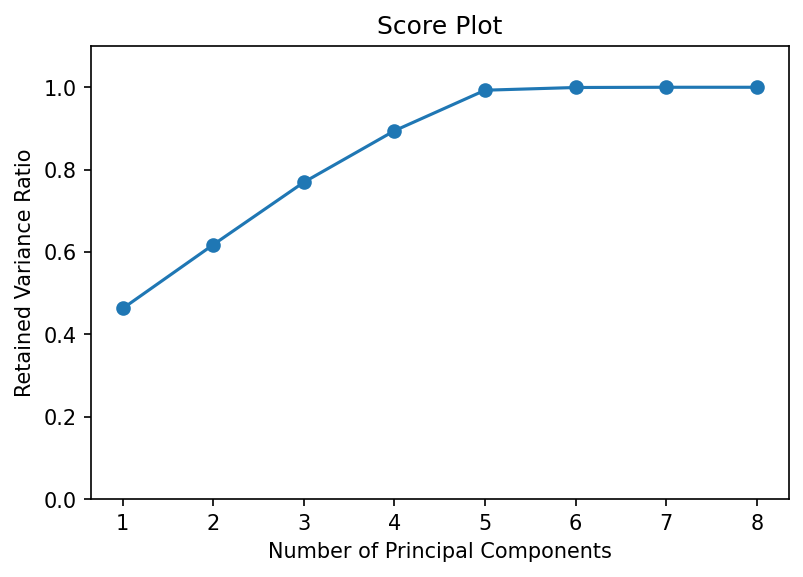

In [8]:
fig, ax = plt.subplots(dpi = 150)
        
ax.plot(range(1, k+1), np.cumsum(var_ratio), marker = 'o')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Retained Variance Ratio')
ax.set_ylim(0, 1.1)
ax.set_title('Score Plot')

#### The above PCA variance plot shows the first five PCs explain the majority of the variance, so the following work will be based on the five PCs.

In [9]:
k = 5
pca_model = PCA(n_components = k)
pca_model.fit(X)
X_k = pca_model.transform(X)
var =  pca_model.explained_variance_
var_ratio = pca_model.explained_variance_ratio_

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
loadings = pd.DataFrame(pca_model.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_X.columns)
loadings

,PC1,PC2,PC3,PC4,PC5
Relative_Compactness,0.50,-0.24,0.00,-0.00,-0.00
Surface_Area,-0.50,0.23,-0.00,-0.00,0.00
Wall_Area,0.03,0.89,-0.00,-0.00,0.00
Roof_Area,-0.50,-0.21,0.00,-0.00,-0.00
Height,0.50,0.21,-0.00,0.00,0.00
Orientation,-0.00,0.00,0.00,1.00,-0.00
Glazing_Area,0.00,-0.00,-0.71,-0.00,-0.71
Glazing_A_Distribution,-0.00,-0.00,-0.71,0.00,0.71


In [13]:
def myplot(score, coeff, labels=None, ax = None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    if ax is None:
        fig, ax = plt.subplots(dpi = 200)
    for i in range(n):
        ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r', alpha = 0.5)
        if labels is None:
            ax.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, "Var" + str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('PC{}'.format(1))
    ax.set_ylabel('PC{}'.format(2))
    plt.grid()
    plt.show()


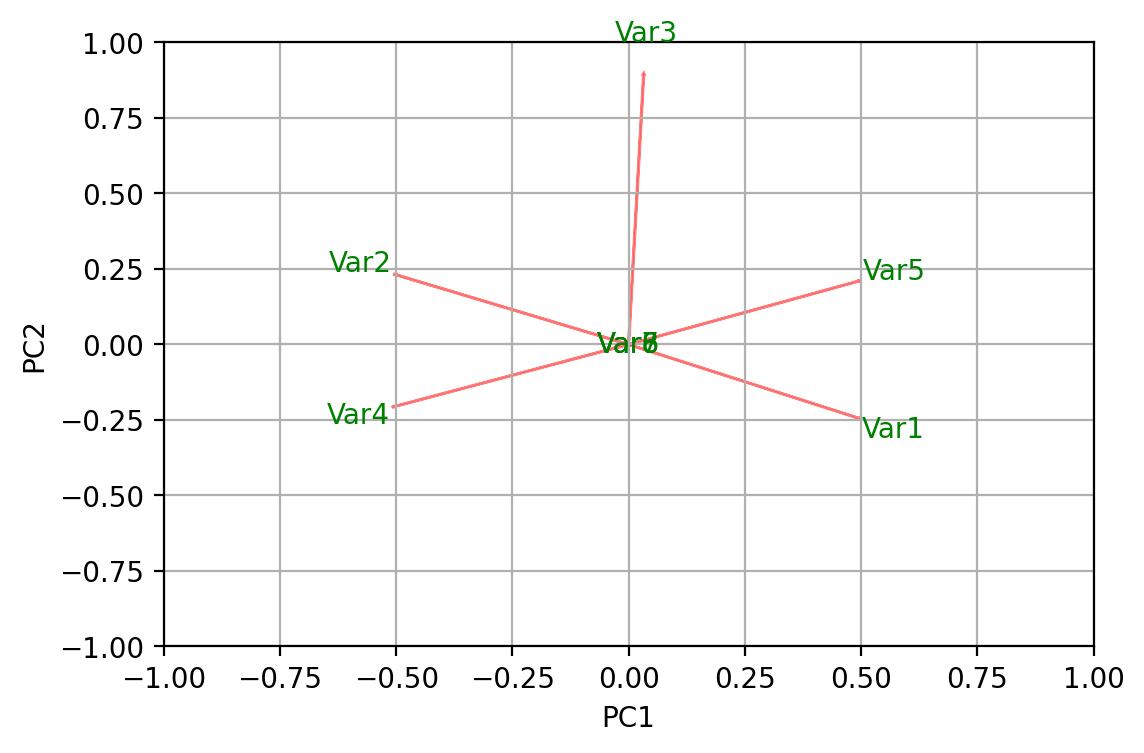

In [15]:
coeff = pca_model.components_.T

myplot(X_k, coeff)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC0224E790>,
      dtype=object)

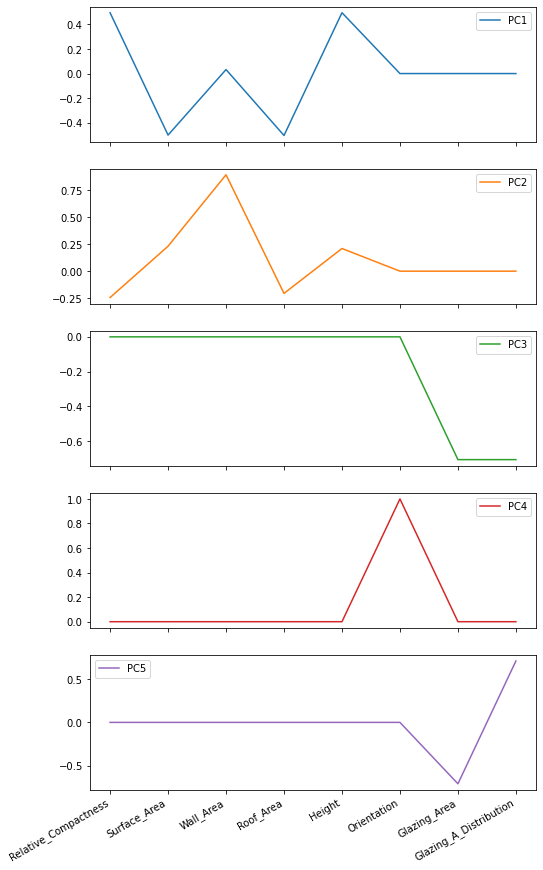

In [22]:
loadings.plot(subplots=True, figsize=(8, 16))

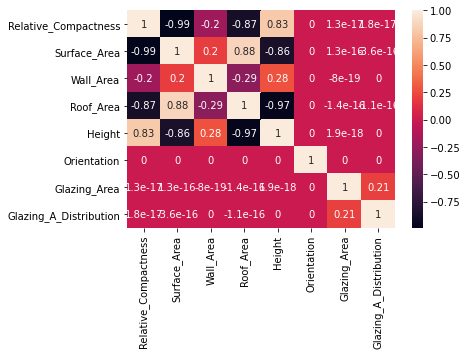

In [23]:
import seaborn as sns 

matrix_corr = df_X.corr()
sns.heatmap(matrix_corr, annot=True)
plt.show()

### Based on the loadings, the 8 original variables have significant contributions to the first 5 PCs. There are some correlations between the variables, for example, 'Relative Compactiveness' versus 'Height'/'Surface Area'/'Roof Area', 'surface area' versus 'roof area'/'height'. 

In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True) 
model.fit(X_k, Y_heat)  #Use the 5 PCs 
r2 = model.score(X_k, Y_heat) 
print('r2 score:', r2)
print('coefficients', model.coef_)

r2 score: 0.8824192427392281
coefficients [ 4.16693352  3.80271374 -2.09979943 -0.02608397 -1.6531288 ]


In [19]:
model = LinearRegression(fit_intercept=True) 
model.fit(X, Y_heat)  # Use the original variables 
r2 = model.score(X, Y_heat) 
print('r2 score:', r2)
print('coefficients', model.coef_)

r2 score: 0.9162021649454062
coefficients [-6.84710802 -3.76696742  0.71136025 -4.01687192  7.29741899 -0.02608397
  2.653721    0.31584383]


In [20]:
model = LinearRegression(fit_intercept=True) 
model.fit(X_k, Y_cool)  #Use the 5 PCs 
r2 = model.score(X_k, Y_cool) 
print('r2 score:', r2)
print('coefficients', model.coef_)

r2 score: 0.8430721115593623
coefficients [ 3.96986923  3.35181266 -1.43006546  0.13585278 -1.34085871]


In [21]:
model = LinearRegression(fit_intercept=True) 
model.fit(X, Y_cool)  # Use the original variables 
r2 = model.score(X, Y_cool) 
print('r2 score:', r2)
print('coefficients', model.coef_)

r2 score: 0.887803550725157
coefficients [-7.48286855 -3.9661084   0.06504155 -3.8989174   7.49672582  0.13585278
  1.95933927  0.0630787 ]


#### PCA is useful in this case. The above regression results demonstrate the 5 PCs effectively represent the original 8 variables. 